In [1]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg

import matplotlib.pyplot as plt
import random, cv2, time, os, shutil, ownlabelme2COCO

In [2]:
import torch
print(torch.__version__)

1.7.1+cu101


Definition des Hauptpfads, der Input-Pfade und der Output-Pfade

In [3]:
dataset_name = "personData200"
path = "/home/julius/Schreibtisch/test_dir/"

dataset_path = path + "1_Datensaetze/{}/".format(dataset_name)
train_set_path = dataset_path + "train_split/"
test_set_path = dataset_path + "test_split/"

starttime = time.strftime("%d,%m,%Y-%H,%M")
model_path = path + "trained_models/detectron2/{}/{}/".format(dataset_name, starttime)

Erstellen des Datensplits, wenn dies noch nicht vorliegt

In [4]:
class uneven_list_error(Exception):
    # raised, when the two lists which are needed to seperate the data are uneven.
    pass

try:
    if not os.path.isdir(train_set_path) & os.path.isdir(test_set_path):
        os.mkdir(train_set_path)
        os.mkdir(test_set_path)
    
        images = sorted([element for element in os.listdir(dataset_path) if element.lower().endswith(".jpg")])
        jsons = sorted([element for element in os.listdir(dataset_path) if element.endswith(".json")])

        if len(images) != len(jsons):
            raise uneven_list_error

        for count in range(len(images)):
            if count % 5 == 0:
                shutil.move(dataset_path + images[count], test_set_path + images[count])
                shutil.move(dataset_path + jsons[count], test_set_path + jsons[count])
            else:
                shutil.move(dataset_path + images[count], train_set_path + images[count])
                shutil.move(dataset_path + jsons[count], train_set_path + jsons[count])
        
        ownlabelme2COCO.main(test_set_path)
        ownlabelme2COCO.main(train_set_path)

except uneven_list_error:
    print("[ERROR] List lengths don't match! There are {} Images and {} json-Files. Please check directory!".format(len(images), len(jsons)))

Einlesen der beiden Datensätze

In [5]:
load_coco_json(train_set_path + "COCO_json/output.json", train_set_path, "train_set")
register_coco_instances("train_set", {}, train_set_path + "COCO_json/output.json", train_set_path)
train_set_metadata = MetadataCatalog.get("train_set")
train_set_data = DatasetCatalog.get("train_set")

load_coco_json(test_set_path + "COCO_json/output.json", test_set_path, "test_set")
register_coco_instances("test_set", {}, test_set_path + "COCO_json/output.json", test_set_path)
test_set_metadata = MetadataCatalog.get("test_set")
test_set_data = DatasetCatalog.get("test_set")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



probeweises Anschauen des gelesenen Datensatzes

(-0.5, 2623.5, 3935.5, -0.5)

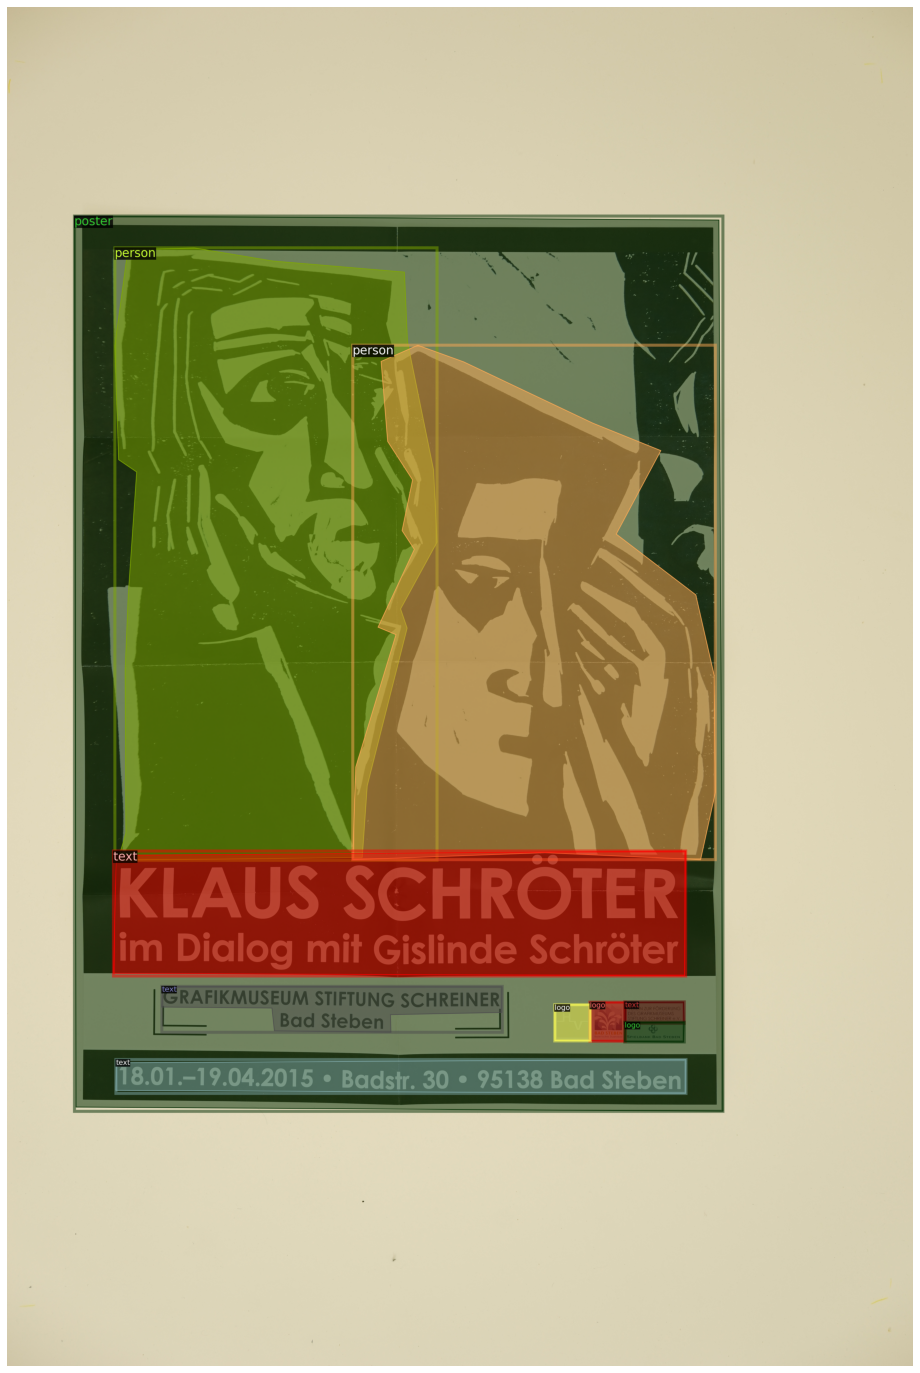

In [6]:
random_image = random.sample(train_set_data, 1)[0]
image = cv2.imread(random_image["file_name"])
visualizer = Visualizer(image, metadata=train_set_metadata, scale=1, instance_mode=ColorMode.SEGMENTATION)
visualization = visualizer.draw_dataset_dict(random_image)
plt.figure(figsize=(25, 25))
plt.imshow(visualization.get_image()[:,:, ::-1])
plt.axis("off")

In [7]:
print(train_set_metadata)

Metadata(evaluator_type='coco', image_root='/home/julius/Schreibtisch/test_dir/1_Datensaetze/personData200/train_split/', json_file='/home/julius/Schreibtisch/test_dir/1_Datensaetze/personData200/train_split/COCO_json/output.json', name='train_set', thing_classes=['poster', 'text', 'person', 'logo'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3})


In [8]:
config = get_cfg()
config.merge_from_file("/home/julius/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
config.DATASETS.TRAIN = ("train_set",)
config.DATASETS.TEST = ("test_set",)
config.DATALOADER.NUM_WORKERS = 2
config.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
config.OUTPUT_DIR = model_path
config.SOLVER.IMS_PER_BATCH = 2
config.SOLVER.REFERENCE_WORLD_SIZE = 1
config.SOLVER.BASE_LR = 0.02
config.SOLVER.MAX_ITER = 150
config.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)
config.MODEL.ROI_HEADS.NUM_CLASSES = 16
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [9]:
print(config)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('test_set',)
  TRAIN: ('train_set',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 're

In [10]:
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
torch.cuda.empty_cache()
trainer = DefaultTrainer(config)
trainer.resume_or_load(resume=False)
trainer.train()

          )
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv3): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
        )
        (1): BottleneckBlock(
          (conv1): Conv2d(
            256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv2): Conv2d(
            64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
          )
          (conv3): Conv2d(
            64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
            (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
          )
        )
        (2): BottleneckBlock(
          (conv1

In [11]:
config_dump = config.dump()
with open(model_path + "config.yaml", "w+") as output_file:
    output_file.write(config_dump)